# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [9]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet'])
import re
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score, accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shahzeb.akhtar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shahzeb.akhtar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Functions to process data

In [10]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [5]:
def create_corr_heatmap(corr_pd, title='', xlabel='', ylabel='', vmin=-1.0, vmax=1.0, center=0):
    cmap = sns.color_palette("coolwarm", 10)
    plt.figure(figsize=(16, 16))
    sns.heatmap(corr_pd, annot=True, fmt=".2f", center=center, square=True, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(rotation=0)
    plt.xticks(rotation=60)

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    if title != '':
        plt.title(title)
    if xlabel != '':
        plt.xlabel(xlabel)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.show()

In [11]:
# Define performance metric for use in grid search scoring object
def performance_metric(y_true, y_pred):
    """Calculate median F1 score for all of the output classifiers
        Args:
        y_true: array. Array containing actual labels.
        y_pred: array. Array containing predicted labels.
        Returns:
        score: float. Mean F1 score for all of the output classifiers
        """
    f1_arr = []
    for i in range(np.shape(y_pred)[1]):
        f1 = f1_score(np.array(y_true)[:, i], y_pred[:, i], average='weighted')
        f1_arr.append(f1)
        
    score = np.mean(f1_arr)
    return score

### 3. Load Data

In [12]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql_table("DataTable", con=engine)

In [13]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
X = df['message'].values
Y = df.iloc[:,4:].values

### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [15]:
pipeline = Pipeline([
         ('vect', CountVectorizer(tokenizer=tokenize)),
         ('tfidf', TfidfTransformer()),
         ('clf', MultiOutputClassifier(RandomForestClassifier()))
     ], verbose=True)

### 5. Train pipeline
- Split data into train and test sets
- Train pipeline

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)
pipeline.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 3) Processing vect, total=  12.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.8s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  56.3s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

### 6. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [17]:
# predict on test data
y_pred = pipeline.predict(X_test)

In [18]:
np.shape(y_pred)

(5642, 35)

In [19]:
#classification_report(y_test, y_pred, labels=range(0, 36), target_names=list(df.columns[4:]))
#y_pred.shape
performance_df_cols = ['accuracy', 'precision', 'recall', 'f1-score']
performance_df_indices = list(df.columns[4:])
df_2d_arr = []
for i in range(np.shape(y_pred)[1]):
    row = []
    row.append(accuracy_score(y_test[:,i], y_pred[:,i]))
    row.append(precision_score(y_test[:,i], y_pred[:,i], average='weighted'))
    row.append(recall_score(y_test[:,i], y_pred[:,i], average='weighted'))
    row.append(f1_score(y_test[:,i], y_pred[:,i], average='weighted'))
    df_2d_arr.append(row)
    
performance_df = pd.DataFrame(df_2d_arr, index=performance_df_indices, columns=performance_df_cols)

In [20]:
performance_df.describe()

,accuracy,precision,recall,f1-score
count,35.000000,35.000000,35.000000,35.000000
mean,0.919917,0.881197,0.919917,0.893177
std,0.096060,0.110995,0.096060,0.113992
min,0.553704,0.517267,0.553704,0.499024
25%,0.905884,0.850531,0.905884,0.866138
50%,0.949840,0.908125,0.949840,0.928514
75%,0.980769,0.962253,0.980769,0.971423
max,0.995746,0.991510,0.995746,0.993624


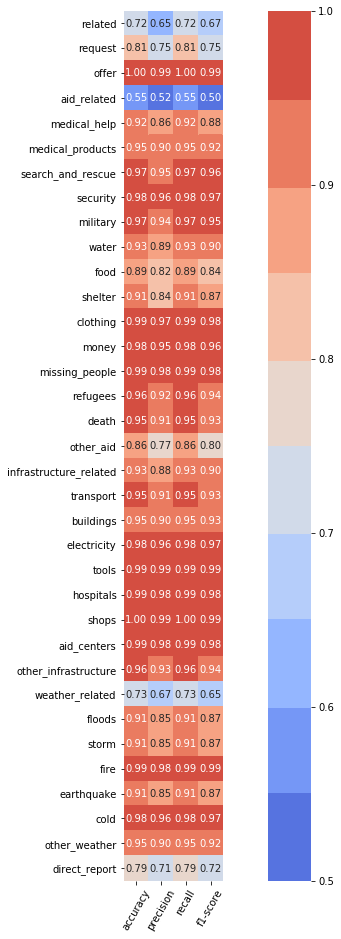

In [21]:
create_corr_heatmap(performance_df, vmin=0.5, center=0.75)

In [22]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x0000021D3B272948>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_fea

### 7. Improve your model
Use grid search to find better parameters. 

In [23]:
parameters = {
    'vect__max_df': [0.25, 0.50, 1.0],                #default - 1.0
    'tfidf__use_idf': [True, False],                  #default - True
    'clf__estimator__n_estimators': [50, 100],        #default - 10
    'clf__estimator__min_samples_split': [2, 4]       #default - 2
}
#Best Parameters: {'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 50, 'tfidf__use_idf': True, 'vect__max_df': 0.25}
#score 0.901

parameters = {
    'vect__max_df': [0.15, 0.25],
    'clf__estimator__n_estimators': [25, 50],        
    'clf__estimator__min_samples_split': [4, 6]       
}
#Best Parameters: {'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 25, 'vect__max_df': 0.15}
#score 0.901

parameters = {
    'vect__max_df': [0.10, 0.20],
    'clf__estimator__n_estimators': [15, 25],       
    'clf__estimator__min_samples_split': [3, 4]      
}
#Best Parameters: {'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 15, 'vect__max_df': 0.1}
#score 0.902

parameters = {
    'vect__max_df': [0.10],                #[0.10, 0.15, 0.20, 0.25]
    'clf__estimator__n_estimators': [15],        #[10, 15, 20, 25]       
    'clf__estimator__min_samples_split': [4]           #[2, 3, 4]   
}
#Best Parameters: {'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 15, 'vect__max_df': 0.1}

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=10, scoring=make_scorer(performance_metric))

### 8. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [24]:
cv.fit(X_train, y_train)

print("\nBest Parameters:", cv.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__estimator__min_samples_split=4, clf__estimator__n_estimators=15, vect__max_df=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] .............. (step 1 of 3) Processing vect, total=   5.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  34.6s
[CV]  clf__estimator__min_samples_split=4, clf__estimator__n_estimators=15, vect__max_df=0.1, score=0.896, total=  46.6s
[CV] clf__estimator__min_samples_split=4, clf__estimator__n_estimators=15, vect__max_df=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.5s remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   5.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  33.7s
[CV]  clf__estimator__min_samples_split=4, clf__estimator__n_estimators=15, vect__max_df=0.1, score=0.896, total=  44.9s
[CV] clf__estimator__min_samples_split=4, clf__estimator__n_estimators=15, vect__max_df=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[Pipeline] .............. (step 1 of 3) Processing vect, total=   5.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  37.1s
[CV]  clf__estimator__min_samples_split=4, clf__estimator__n_estimators=15, vect__max_df=0.1, score=0.897, total=  49.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=   8.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.0min

Best Parameters: {'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 15, 'vect__max_df': 0.1}


In [25]:
y_pred_new = cv.predict(X_test)

In [26]:
df_cols = ['accuracy', 'precision', 'recall', 'f1-score']
indices = []
df_2d_arr = []
for i, col in enumerate(list(df.columns[4:])):
    indices.append(col)
    row = []
    row.append(accuracy_score(y_test[:,i], y_pred_new[:,i]))
    row.append(precision_score(y_test[:,i], y_pred_new[:,i], average='weighted'))
    row.append(recall_score(y_test[:,i], y_pred_new[:,i], average='weighted'))
    row.append(f1_score(y_test[:,i], y_pred_new[:,i], average='weighted'))
    df_2d_arr.append(row)
    
score_df = pd.DataFrame(df_2d_arr, index=indices, columns=df_cols)

In [27]:
score_df.describe()

,accuracy,precision,recall,f1-score
count,35.000000,35.000000,35.000000,35.000000
mean,0.919937,0.880968,0.919937,0.894065
std,0.095194,0.110448,0.095194,0.111063
min,0.552464,0.526830,0.552464,0.519425
25%,0.904644,0.848370,0.904644,0.866857
50%,0.949840,0.908125,0.949840,0.928514
75%,0.980858,0.962254,0.980858,0.971467
max,0.995746,0.991510,0.995746,0.993624


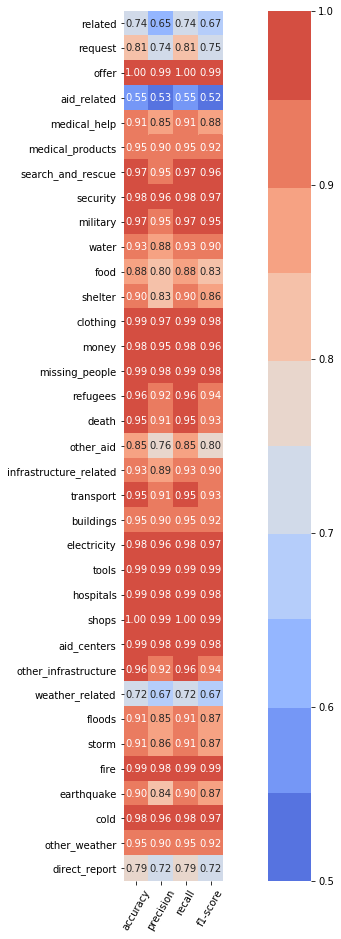

In [28]:
create_corr_heatmap(score_df, vmin=0.5, center=0.75)

In [29]:
score_df.to_sql('ResultTable', engine, index=False, if_exists= 'replace')

### 9. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 10. Export your model as a pickle file

In [53]:
# save the model to disk
filename = 'saved_model.pkl'
pickle.dump(cv, open(filename, 'wb'))

### 11. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.